In [1]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import imgaug as ia
import os

from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, shuffle

from keras.utils import Sequence
from keras.utils import to_categorical
from keras import backend as K

import warnings
warnings.filterwarnings("ignore")

SEED = 4
SIZE = 128
NUM_CLASSES = 5

ImportError: cannot import name '_validate_lengths'

In [3]:
import tensorflow as tf
from tensorflow.python.client import device_lib

# print(device_lib.list_local_devices())
# sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# tf.test.is_gpu_available()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\env3-gpu\lib\site-packages\tensorflow\python\platform\self_check.py", line 75, in preload_check
    ctypes.WinDLL(build_info.cudart_dll_name)
  File "C:\ProgramData\Anaconda3\envs\env3-gpu\lib\ctypes\__init__.py", line 351, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: [WinError 126] Не найден указанный модуль

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\env3-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3265, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-d9d9ecc3cda9>", line 1, in <module>
    import tensorflow as tf
  File "C:\ProgramData\Anaconda3\envs\env3-gpu\lib\site-packages\tensorflow\__init__.py", line 99, in <module>
    from tensorflow_core import *
  File "C:\ProgramData\Anaconda3\envs\env3-gpu\lib\site-packages\tensorflow_cor

TypeError: Can't convert 'list' object to str implicitly

In [10]:
dataset_path = '../../Downloads/aptos2019-blindness-detection/'
train_imgs_path = os.path.join(dataset_path, 'train_images/')
test_imgs_path = os.path.join(dataset_path, 'test_images/')

train_df_path = os.path.join(dataset_path, 'train.csv')
test_df_path = os.path.join(dataset_path, 'test.csv')

df_train = pd.read_csv(train_df_path)

In [11]:
X = df_train['id_code']
y = df_train['diagnosis']

In [12]:
y = to_categorical(y, num_classes=NUM_CLASSES)
train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.15,
                                                      stratify=y, random_state=SEED)

In [13]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential(
        [
            # apply the following augmenters to most images
            iaa.Fliplr(0.5), # horizontally flip 50% of all images
            iaa.Flipud(0.2), # vertically flip 20% of all images
            sometimes(iaa.Affine(
                scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 80-120% of their size, individually per axis
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
                rotate=(-10, 10), # rotate by -45 to +45 degrees
                shear=(-5, 5), # shear by -16 to +16 degrees
                order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
            )),
            # execute 0 to 5 of the following (less important) augmenters per image
            # don't execute all of them, as that would often be way too strong
            iaa.SomeOf((0, 5),
                [
                    sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                    iaa.OneOf([
                        iaa.GaussianBlur((0, 1.0)), # blur images with a sigma between 0 and 3.0
                        iaa.AverageBlur(k=(3, 5)), # blur image using local means with kernel sizes between 2 and 7
                        iaa.MedianBlur(k=(3, 5)), # blur image using local medians with kernel sizes between 2 and 7
                    ]),
                    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.9, 1.1)), # sharpen images
                    iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                    # search either for all edges or for directed edges,
                    # blend the result with the original image using a blobby mask
                    iaa.SimplexNoiseAlpha(iaa.OneOf([
                        iaa.EdgeDetect(alpha=(0.5, 1.0)),
                        iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                    ])),
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.01*255), per_channel=0.5), # add gaussian noise to images
                    iaa.OneOf([
                        iaa.Dropout((0.01, 0.05), per_channel=0.5), # randomly remove up to 10% of the pixels
                        iaa.CoarseDropout((0.01, 0.03), size_percent=(0.01, 0.02), per_channel=0.2),
                    ]),
                    iaa.Invert(0.01, per_channel=True), # invert color channels
                    iaa.Add((-2, 2), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                    iaa.AddToHueAndSaturation((-1, 1)), # change hue and saturation
                    # either change the brightness of the whole image (sometimes
                    # per channel) or change the brightness of subareas
                    iaa.OneOf([
                        iaa.Multiply((0.9, 1.1), per_channel=0.5),
                        iaa.FrequencyNoiseAlpha(
                            exponent=(-1, 0),
                            first=iaa.Multiply((0.9, 1.1), per_channel=True),
                            second=iaa.ContrastNormalization((0.9, 1.1))
                        )
                    ]),
                    sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                    sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                    sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
                ],
                random_order=True
            )
        ],
        random_order=True)

In [14]:
class My_Generator(Sequence):

    def __init__(self, image_filenames, labels,
                 batch_size, is_train=True,
                 mix=False, augment=False):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size
        self.is_train = is_train
        self.is_augment = augment
        if(self.is_train):
            self.on_epoch_end()
        self.is_mix = mix

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        if(self.is_train):
            return self.train_generate(batch_x, batch_y)
        return self.valid_generate(batch_x, batch_y)

    def on_epoch_end(self):
        if(self.is_train):
            self.image_filenames, self.labels = shuffle(self.image_filenames, self.labels)
        else:
            pass
    
    def mix_up(self, x, y):
        lam = np.random.beta(0.2, 0.4)
        ori_index = np.arange(int(len(x)))
        index_array = np.arange(int(len(x)))
        np.random.shuffle(index_array)        
        
        mixed_x = lam * x[ori_index] + (1 - lam) * x[index_array]
        mixed_y = lam * y[ori_index] + (1 - lam) * y[index_array]
        
        return mixed_x, mixed_y

    def train_generate(self, batch_x, batch_y):
        batch_images = []
        for (sample, label) in zip(batch_x, batch_y):
            img = cv2.imread(train_imgs_path + sample + '.png')
            img = resize_image(img, SIZE)
            img = subtract_median_bg_image(img)
            img = adjust_gamma(img)
            img = radius_reduction(img)
            
            if(self.is_augment):
                img = seq.augment_image(img)
            batch_images.append(img)
        batch_images = np.array(batch_images, np.float32) / 255
        batch_y = np.array(batch_y, np.float32)
        if(self.is_mix):
            batch_images, batch_y = self.mix_up(batch_images, batch_y)
        return batch_images, batch_y

    def valid_generate(self, batch_x, batch_y):
        batch_images = []
        for (sample, label) in zip(batch_x, batch_y):
            img = cv2.imread(train_imgs_path + sample + '.png')
            img = resize_image(img, SIZE)
            img = subtract_median_bg_image(img)
            img = adjust_gamma(img)
            img = radius_reduction(img)
            
            batch_images.append(img)
        batch_images = np.array(batch_images, np.float32) / 255
        batch_y = np.array(batch_y, np.float32)
        return batch_images, batch_y

In [23]:
train_generator = My_Generator(train_x, train_y, 16, is_train=True)

items = train_generator[4]

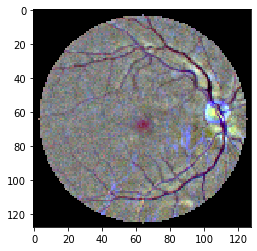

In [24]:
plt.imshow(items[0][2])

In [ ]:
2+2

In [31]:
from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())
X_1 = tf.placeholder(tf.float32, name = "X_1")
X_2 = tf.placeholder(tf.float32, name = "X_2")

multiply = tf.multiply(X_1, X_2, name = "multiply")
with tf.Session() as session:
    result = session.run(multiply, feed_dict={X_1:[1,2,3], X_2:[4,5,6]})
# #     print(result)

InternalError: failed to get compute capability major for device: UNKNOWN ERROR (1); 0

In [17]:
def info_image(im):
    # Compute the center (cx, cy) and radius of the eye
    cy = im.shape[0]//2
    midline = im[cy,:]
    midline = np.where(midline>midline.mean()/3)[0]

    if len(midline)>im.shape[1]//2:
        x_start, x_end = np.min(midline), np.max(midline)
    else: # This actually rarely happens p~1/10000
        x_start, x_end = im.shape[1]//10, 9*im.shape[1]//10
    cx = (x_start + x_end)/2
    r = (x_end - x_start)/2
    return cx, cy, r

In [18]:
def resize_image(im, IMAGE_SIZE):
    # Crops, resizes and potentially augments the image to IMAGE_SIZE
    cx, cy, r = info_image(im)
    scaling = IMAGE_SIZE/(2*r)
    rotation = 0
    
    M = cv2.getRotationMatrix2D((cx,cy), rotation, scaling)
    M[0,2] -= cx - IMAGE_SIZE/2
    M[1,2] -= cy - IMAGE_SIZE/2
    return cv2.warpAffine(im,M,(IMAGE_SIZE,IMAGE_SIZE)) # This is the most important line

In [19]:
def subtract_median_bg_image(im):
    k = np.max(im.shape)//20*2+1
    bg = cv2.medianBlur(im, k)
    return cv2.addWeighted (im, 4, bg, -4, 128)

In [20]:

def radius_reduction(img):
    h, w, c=img.shape
    frame0 = np.zeros((h, w, c), dtype = np.uint8)
    
    cv2.circle(frame0, (int(np.floor(w / 2)), int(np.floor(h / 2))),
                       int(np.floor((h * 96) / float(2 * 100))), (255, 255, 255), -1)
    
    frame1 = cv2.cvtColor(frame0, cv2.COLOR_BGR2GRAY)
    res = cv2.bitwise_and(img, img, mask=frame1)
    return res

In [21]:
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

In [22]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = DenseNet121(include_top=False,
                   weights=None,
                   input_tensor=input_tensor)
    base_model.load_weights("../input/densenet-keras/DenseNet-BC-121-32-no-top.h5")
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output) 
    return model